I am using this Notebook to come up with a POC for a Automatic Model retraining and Serving section for the the stock app.

### Mag 7 Stocks
Only Interested in using hte Magnificent 7 stocks for now as I think I will need a model per stock (think fine tuning here maybe in the future if automl doesnt pull through). 
So that's: 
- AAPL
- AMZN
- GOOG 
- MSFT 
- META
- NVDA
- TSLA 

In [3]:
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import joblib

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Helper Functions
def fetch_stock_data(ticker, start_date="2020-01-01", end_date="2024-12-31"):
    import yfinance as yf
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def prepare_dnn_data(data, look_back=30):
    """
    Prepare sequences for time-series forecasting using Dense Neural Network.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

def train_dense_nn(X_train, y_train, test_size=0.2, epochs=100, batch_size=32, patience=10):
    """
    Train a Dense Neural Network for regression using Keras.
    """
    # Split data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=test_size, random_state=42
    )

    # Define the model
    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train.shape[1]),  # First layer
        BatchNormalization(),                                      # Batch normalization
        Dropout(0.2),                                              # Dropout for regularization
        
        Dense(64, activation='relu'),                              # Second layer
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),                              # Third layer
        BatchNormalization(),
        Dropout(0.2),

        Dense(1)  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
    )

    # Train the model
    history = model.fit(
        X_train_split, y_train_split,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return model

# Main Training Script
magnificent_7 = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA"]
models_dir = "models"
look_back = 10
test_size = 30

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

for stock in magnificent_7:
    print(f"Processing stock: {stock}")

    stock_data = fetch_stock_data(stock)
    close_prices = stock_data["Close"].values.reshape(-1, 1)

    train_close_prices = close_prices[:-test_size]
    test_close_prices = close_prices[-test_size:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_close_prices)
    test_scaled = scaler.transform(test_close_prices)

    X_train, y_train = prepare_dnn_data(train_scaled, look_back)

    if len(X_train) == 0:
        print(f"Not enough data for {stock}. Skipping.")
        continue

    # Train the model
    model = train_dense_nn(X_train, y_train, test_size=0.2, epochs=100, batch_size=32, patience=10)

    # Save the model and scaler
    model.save(f"{models_dir}/{stock}_dnn.h5")
    joblib.dump(scaler, f"{models_dir}/{stock}_scaler.pkl")

    print(f"DNN model for {stock} saved!")


[*********************100%***********************]  1 of 1 completed

Processing stock: AAPL
Epoch 1/100



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9471 - mean_squared_error: 1.9471 - val_loss: 0.1317 - val_mean_squared_error: 0.1317 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.2594 - mean_squared_error: 1.2594 - val_loss: 0.0662 - val_mean_squared_error: 0.0662 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.7649 - mean_squared_error: 0.7649 - val_loss: 0.0581 - val_mean_squared_error: 0.0581 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.7589 - mean_squared_error: 0.7589 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.5444 - mean_squared_error: 0.5444 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.4470 - mean_squared_error: 0.4470 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 

[*********************100%***********************]  1 of 1 completed

DNN model for AAPL saved!
Processing stock: MSFT



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4018 - mean_squared_error: 1.4018 - val_loss: 0.1422 - val_mean_squared_error: 0.1422 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.9037 - mean_squared_error: 0.9037 - val_loss: 0.0823 - val_mean_squared_error: 0.0823 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.6347 - mean_squared_error: 0.6347 - val_loss: 0.0616 - val_mean_squared_error: 0.0616 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.4903 - mean_squared_error: 0.4903 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.4372 - mean_squared_error: 0.4372 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.3381 - mean_squared_error: 0.3381 - val_loss: 0.0201 - val_mean_squared_er

DNN model for MSFT saved!
Processing stock: AMZN


[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2353 - mean_squared_error: 2.2353 - val_loss: 0.2225 - val_mean_squared_error: 0.2225 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 1.1022 - mean_squared_error: 1.1022 - val_loss: 0.1954 - val_mean_squared_error: 0.1954 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.8634 - mean_squared_error: 0.8634 - val_loss: 0.1931 - val_mean_squared_error: 0.1931 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.7267 - mean_squared_error: 0.7267 - val_loss: 0.1198 - val_mean_squared_error: 0.1198 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.5201 - mean_squared_error: 0.5201 - val_loss: 0.0875 - val_mean_squared_error: 0.0875 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.4670 - mean_squared_error: 0.4670 - val_loss: 0.1055 - val_mean_squared_error: 0.1055 

DNN model for AMZN saved!
Processing stock: GOOGL


[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0758 - mean_squared_error: 2.0758 - val_loss: 0.1275 - val_mean_squared_error: 0.1275 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 1.0665 - mean_squared_error: 1.0665 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.7619 - mean_squared_error: 0.7619 - val_loss: 0.0567 - val_mean_squared_error: 0.0567 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.5982 - mean_squared_error: 0.5982 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.5140 - mean_squared_error: 0.5140 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5051 - mean_squared_error: 0.5051 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - 

DNN model for GOOGL saved!
Processing stock: META


[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4570 - mean_squared_error: 2.4570 - val_loss: 0.0836 - val_mean_squared_error: 0.0836 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.8847 - mean_squared_error: 0.8847 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.6407 - mean_squared_error: 0.6407 - val_loss: 0.0816 - val_mean_squared_error: 0.0816 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.5352 - mean_squared_error: 0.5352 - val_loss: 0.0653 - val_mean_squared_error: 0.0653 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 0.4295 - mean_squared_error: 0.4295 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.4124 - mean_squared_error: 0.4124 - val_loss: 0.0498 - val_mean_squared_error: 0.0498 

DNN model for META saved!
Processing stock: TSLA


[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0485 - mean_squared_error: 2.0485 - val_loss: 0.1422 - val_mean_squared_error: 0.1422 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 1.1001 - mean_squared_error: 1.1001 - val_loss: 0.0692 - val_mean_squared_error: 0.0692 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.7483 - mean_squared_error: 0.7483 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.6084 - mean_squared_error: 0.6084 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.5179 - mean_squared_error: 0.5179 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.4374 - mean_squared_error: 0.4374 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 

DNN model for TSLA saved!
Processing stock: NVDA


[*********************100%***********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0410 - mean_squared_error: 2.0410 - val_loss: 0.0811 - val_mean_squared_error: 0.0811 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 1.2142 - mean_squared_error: 1.2142 - val_loss: 0.0738 - val_mean_squared_error: 0.0738 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.9542 - mean_squared_error: 0.9542 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7417 - mean_squared_error: 0.7417 - val_loss: 0.0732 - val_mean_squared_error: 0.0732 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.5676 - mean_squared_error: 0.5676 - val_loss: 0.0620 - val_mean_squared_error: 0.0620 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.5951 - mean_squared_error: 0.5951 - val_loss: 0.0321 - val_mean_squared_erro

DNN model for NVDA saved!


Loading model for: AAPL


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


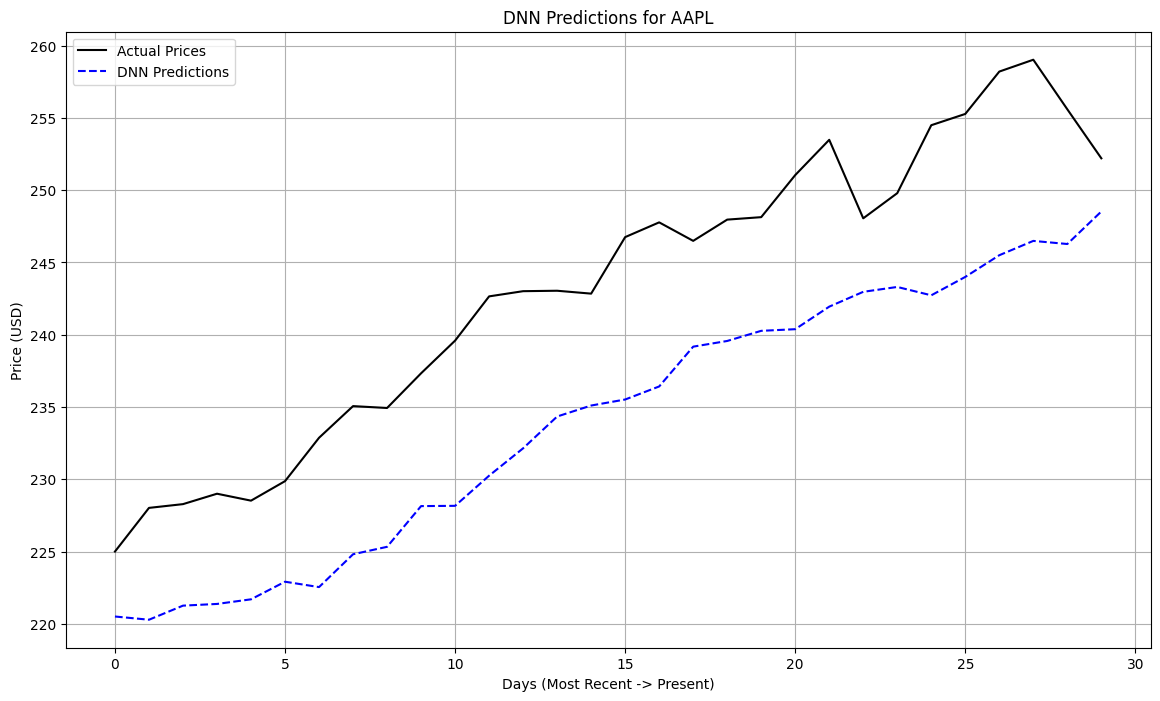

Loading model for: MSFT


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


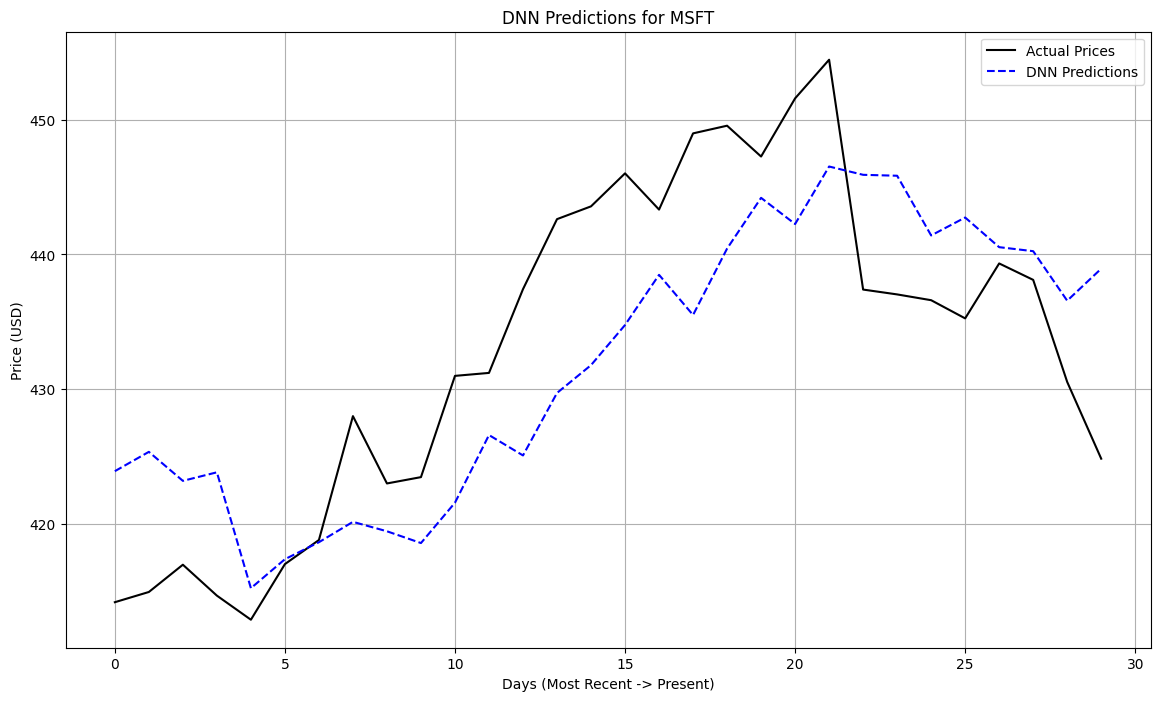

Loading model for: AMZN


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


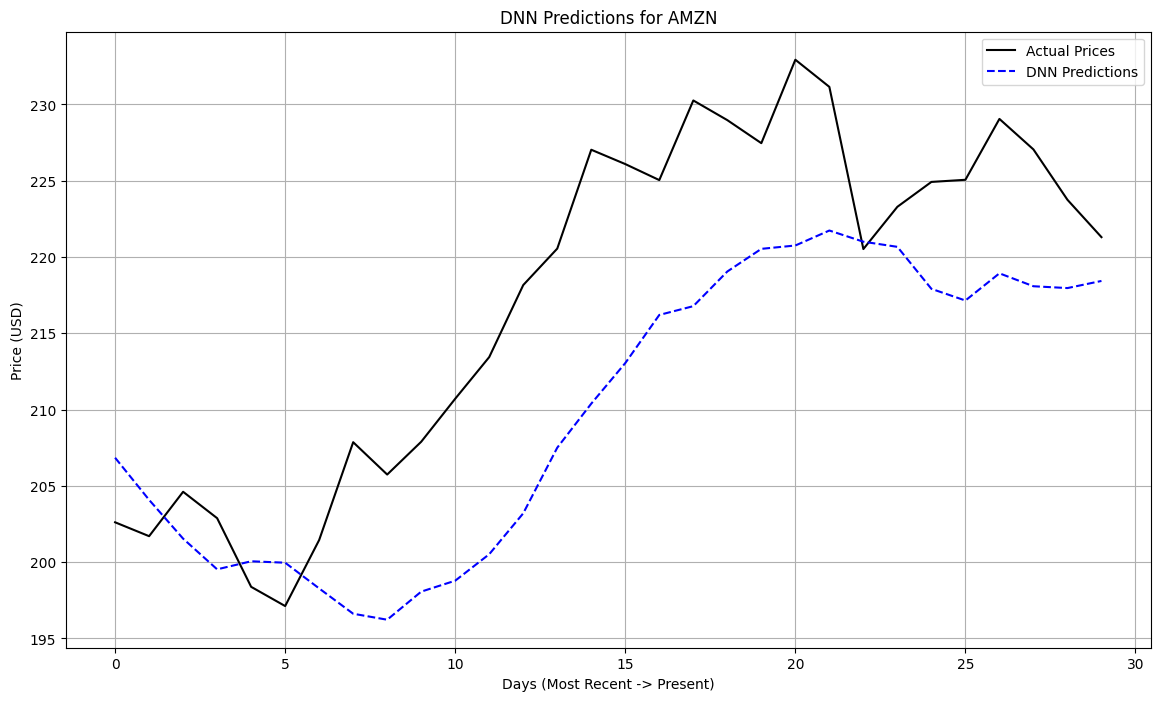

Loading model for: GOOGL


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


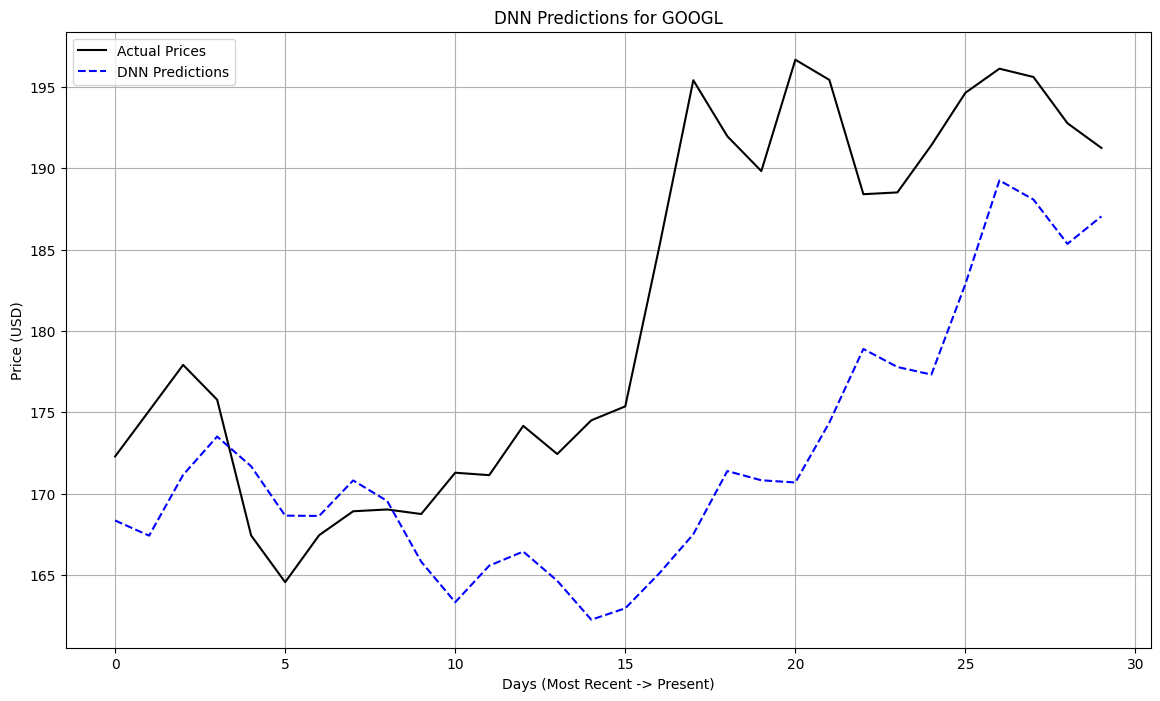

[*********************100%***********************]  1 of 1 completed

Loading model for: META


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


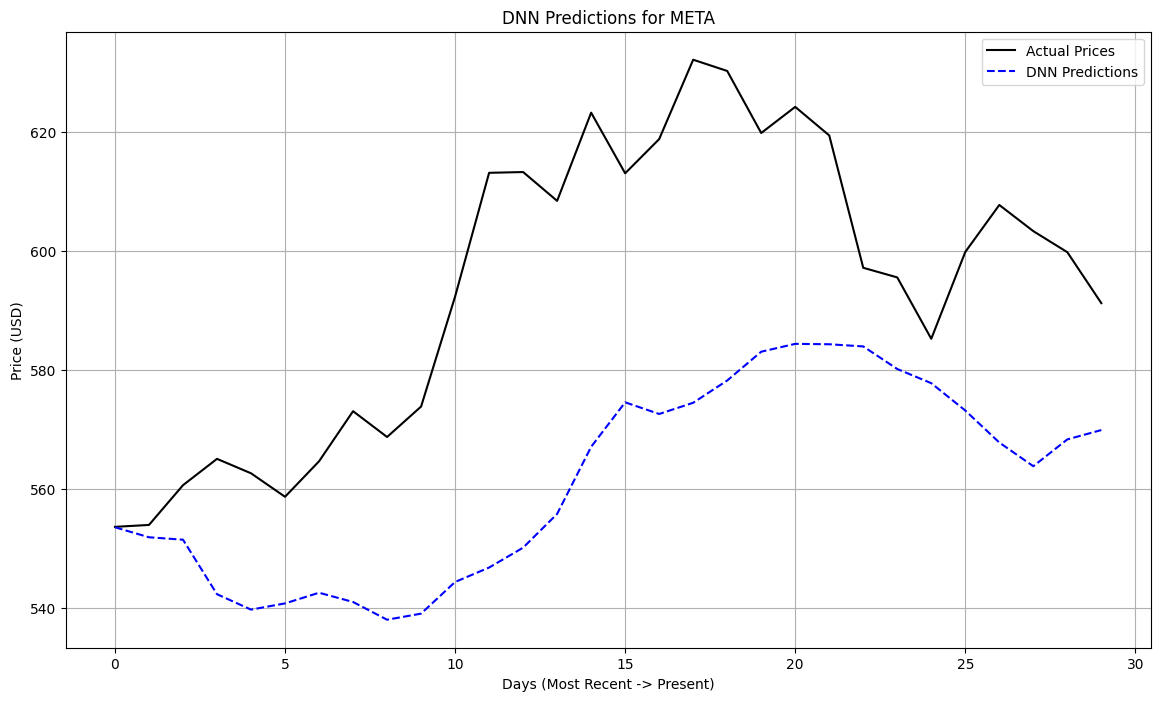

Loading model for: TSLA


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


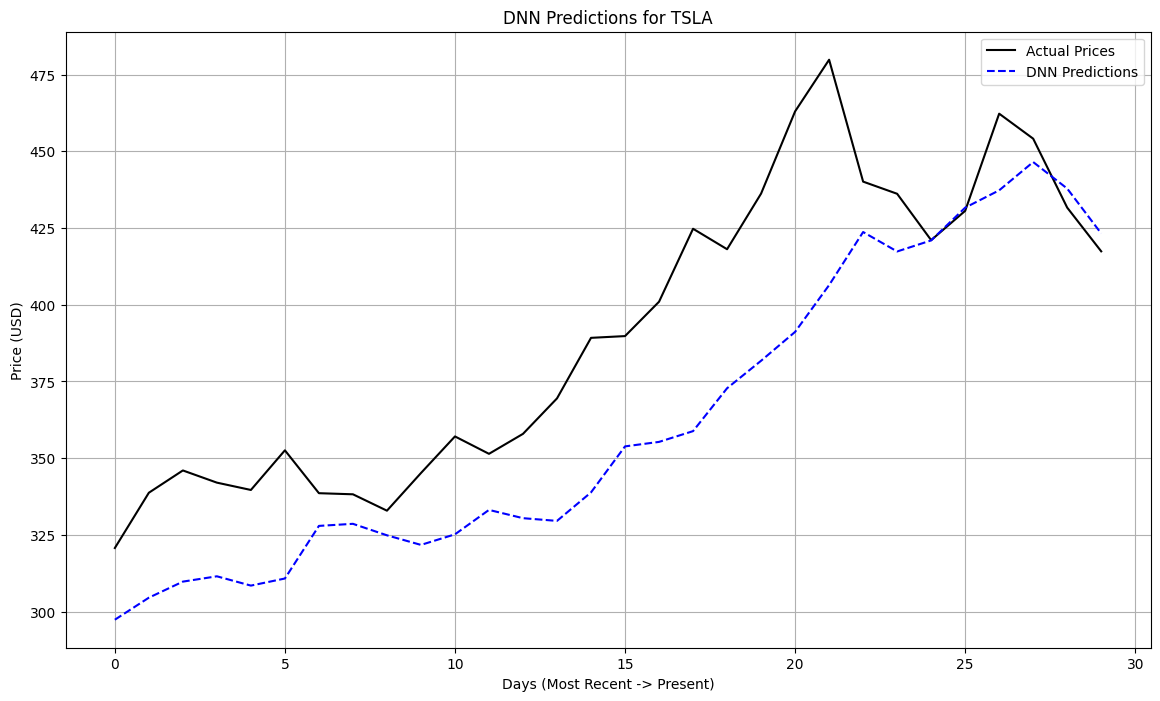

Loading model for: NVDA


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


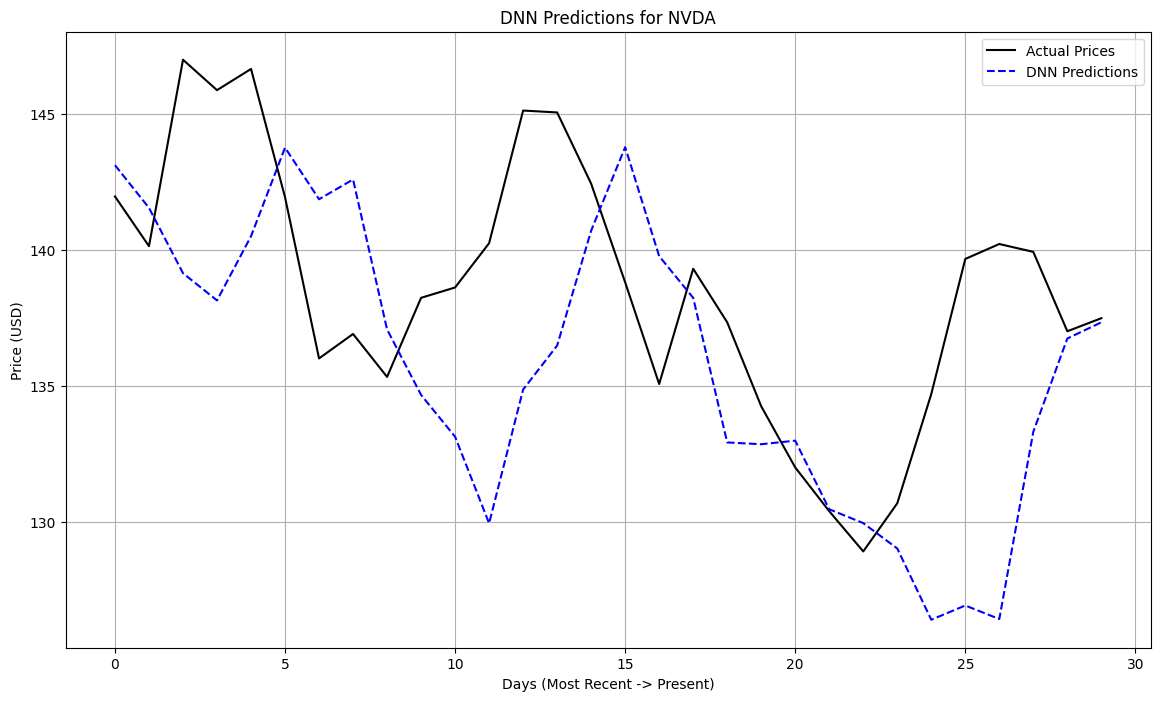


Model Accuracy (MSE):
   Stock      DNN MSE
0   AAPL    88.290890
1   MSFT    68.128725
2   AMZN    83.860320
3  GOOGL   149.675292
4   META  1378.454516
5   TSLA  1280.770772
6   NVDA    36.891020


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model

def prepare_dnn_data(data, look_back=30):
    """
    Prepare sequences for time-series forecasting using Dense Neural Network.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

def fetch_stock_data(ticker, start_date="2020-01-01", end_date="2024-12-31"):
    import yfinance as yf
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Set up
magnificent_7 = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA"]
models_dir = "models"
look_back = 10
test_size = 30

results = []

for stock in magnificent_7:
    print(f"Loading model for: {stock}")

    # Load scaler and model
    scaler = joblib.load(f"{models_dir}/{stock}_scaler.pkl")
    model = load_model(f"{models_dir}/{stock}_dnn.h5")

    # Fetch stock data
    stock_data = fetch_stock_data(stock)
    close_prices = stock_data["Close"].values.reshape(-1, 1)

    # Apply the same scaler that was fit on training data
    scaled_data = scaler.transform(close_prices)

    # Prepare data for prediction
    X_all, y_all = prepare_dnn_data(scaled_data, look_back)

    if len(X_all) < test_size:
        print(f"Not enough data for {stock}. Skipping.")
        continue

    X_test = X_all[-test_size:]
    y_test = y_all[-test_size:]

    # Make predictions
    predictions_scaled = model.predict(X_test).flatten()

    # Inverse transform predictions and actuals
    predictions = scaler.inverse_transform(
        predictions_scaled.reshape(-1, 1)
    ).flatten()

    actual_prices = scaler.inverse_transform(
        y_test.reshape(-1, 1)
    ).flatten()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(actual_prices, predictions)

    # Append results
    results.append({
        "Stock": stock,
        "DNN MSE": mse
    })

    # Plot the results
    plt.figure(figsize=(14, 8))
    plt.plot(actual_prices, label="Actual Prices", color="black")
    plt.plot(predictions, label="DNN Predictions", color="blue", linestyle="dashed")
    plt.title(f"DNN Predictions for {stock}")
    plt.xlabel("Days (Most Recent -> Present)")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

# Display results in a table
results_df = pd.DataFrame(results)
print("\nModel Accuracy (MSE):")
print(results_df)

# Optional: Save results to a CSV
results_df.to_csv("dnn_model_accuracy_results.csv", index=False)
